# Speech Emotion Recognition

### https://www.kaggle.com/shivamburnwal/speech-emotion-recognition/notebook

### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Attention
from tensorflow.keras.utils import to_categorical
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2021-12-11 18:34:31.316189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 18:34:31.316223: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Ravdess Dataframe

In [2]:
# Paths for data.
Ravdess = "data/"

#Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    if not os.path.isdir(Ravdess + dir):
        continue
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(15)

Emotions                                    Path
0   neutral  data/Actor_01/03-01-01-01-01-01-01.wav
1   neutral  data/Actor_01/03-01-01-01-01-02-01.wav
2   neutral  data/Actor_01/03-01-01-01-02-01-01.wav
3   neutral  data/Actor_01/03-01-01-01-02-02-01.wav
4      calm  data/Actor_01/03-01-02-01-01-01-01.wav
5      calm  data/Actor_01/03-01-02-01-01-02-01.wav
6      calm  data/Actor_01/03-01-02-01-02-01-01.wav
7      calm  data/Actor_01/03-01-02-01-02-02-01.wav
8      calm  data/Actor_01/03-01-02-02-01-01-01.wav
9      calm  data/Actor_01/03-01-02-02-01-02-01.wav
10     calm  data/Actor_01/03-01-02-02-02-01-01.wav
11     calm  data/Actor_01/03-01-02-02-02-02-01.wav
12    happy  data/Actor_01/03-01-03-01-01-01-01.wav
13    happy  data/Actor_01/03-01-03-01-01-02-01.wav
14    happy  data/Actor_01/03-01-03-01-02-01-01.wav

In [4]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                    Path
0  neutral  data/Actor_01/03-01-01-01-01-01-01.wav
1  neutral  data/Actor_01/03-01-01-01-01-02-01.wav
2  neutral  data/Actor_01/03-01-01-01-02-01-01.wav
3  neutral  data/Actor_01/03-01-01-01-02-02-01.wav
4     calm  data/Actor_01/03-01-02-01-01-01-01.wav

### Data Visualisation and Exploration

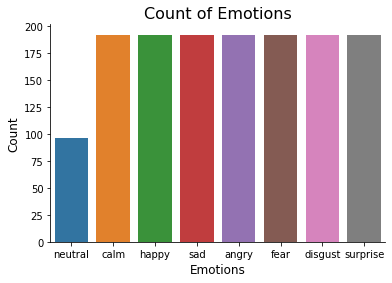

In [6]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Plotting waveplots and spectograms for audio signals

### Waveplots illustrates the loudness of the audio at a given time
### Spectograms are  a visual representation of the spectrum of frequencies of sound or other signals as they vary with time, it’s a representation of frequencies changing with respect to time for given audio/music signals.

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

Data from our voices

In [6]:
neutral_data, sampling_rate = librosa.load('data/neutral.wav')
scared_data, _ = librosa.load('data/scared.wav')
surprised_data, _ = librosa.load('data/surprised.wav')
angry_data, _ = librosa.load('data/angry.wav')

In [7]:
sampling_rate

22050

In [35]:
surprised_data = surprised_data[10000:50000]

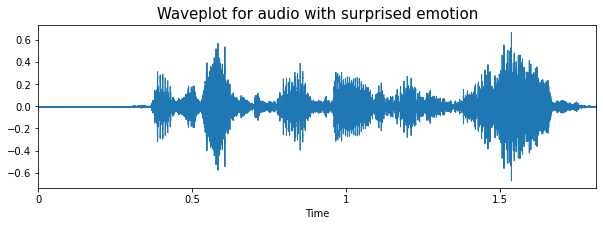

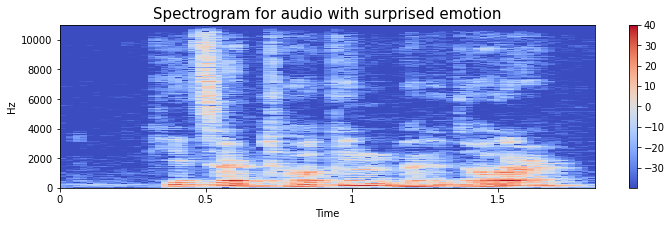

In [58]:
create_waveplot(surprised_data, sampling_rate, 'surprised')
create_spectrogram(surprised_data, sampling_rate, 'surprised')
Audio('data/surprised.wav')

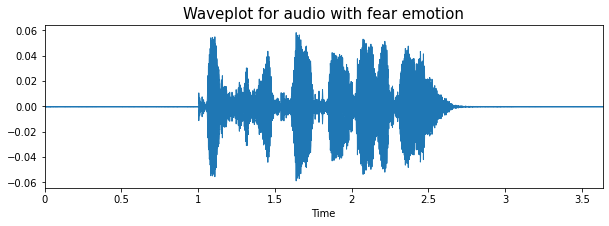

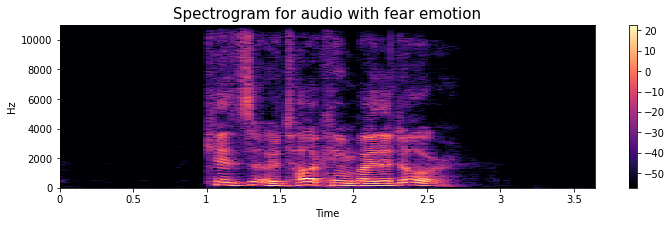

In [8]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [9]:
sampling_rate

22050

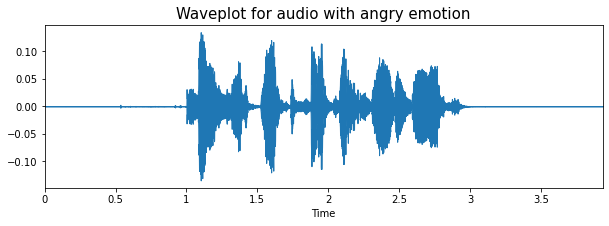

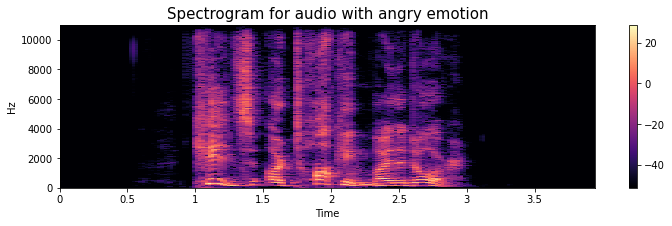

In [11]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

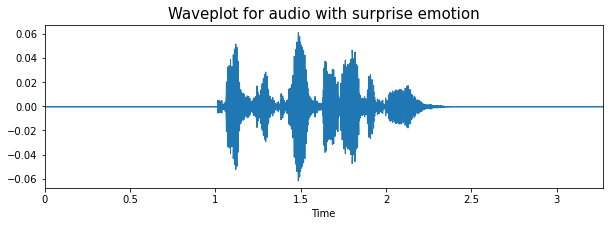

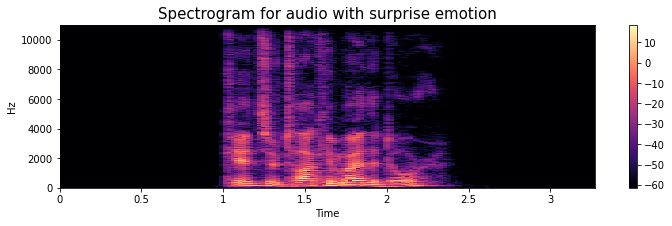

In [59]:
emotion='surprise'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

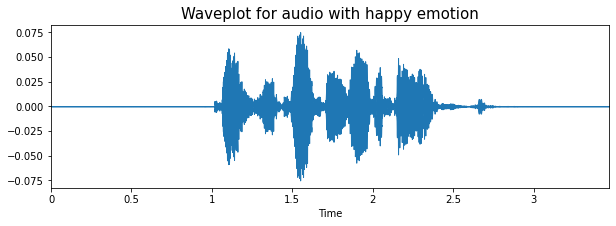

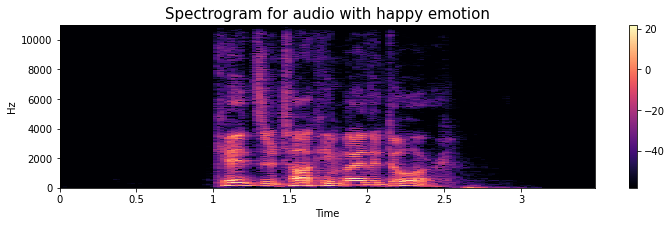

In [13]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

### Data Augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set

### To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed
### The objective is to make our model invariant to those perturbations and enhace its ability to generalize
### In order to this to work adding the perturbations must conserve the same label as the original training sample
### In images data augmention can be performed by shifting the image, zooming, rotating ...
### Checking which augmentation techniques works better for our dataset

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

### Simple audio

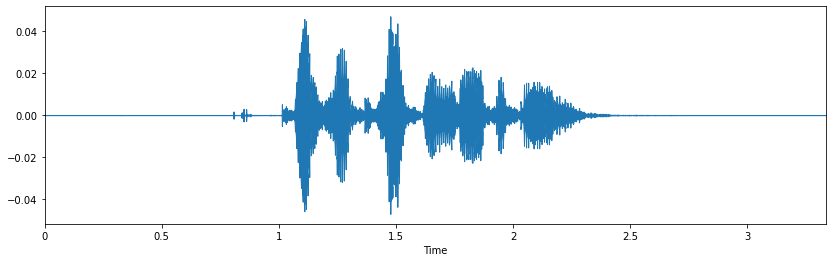

In [15]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

### Noise Injection is a very good augmentation technique because of which we can assure the training model is not overfitted

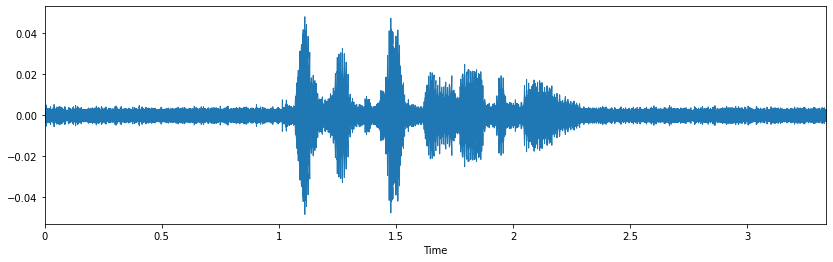

In [16]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

###  Stretching

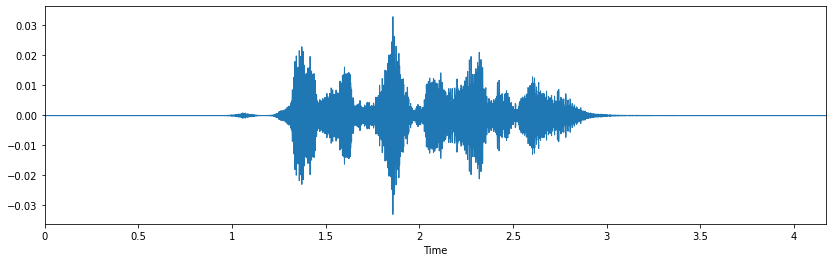

In [17]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Shifting

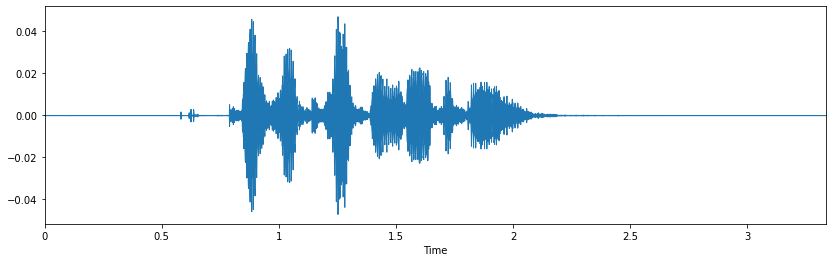

In [18]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Pitching

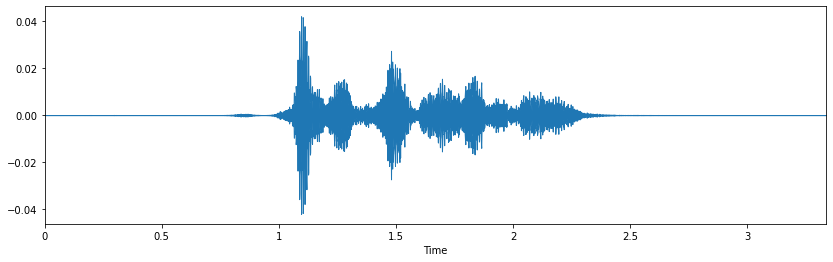

In [20]:
x = pitch(data, sample_rate, pitch_factor=-1.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Feature Extraction

### Extracting 5 features:

### Zero Crossing Rate
### Chroma_stft
### MFCC
### RMS(root mean square) value
### MelSpectogram to train our model.

In [18]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path, augmentation=True):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    if augmentation:
        # data with noise
        noise_data = noise(data)
        res2 = extract_features(noise_data)
        result = np.vstack((result, res2)) # stacking vertically

        # data with stretching and pitching
        new_data = stretch(data)
        data_stretch_pitch = pitch(new_data, sample_rate)
        res3 = extract_features(data_stretch_pitch)
        result = np.vstack((result, res3)) # stacking vertically

        for pitch_factor in (-1.5, -.7, 1.5):
            new_data = pitch(data, sample_rate, pitch_factor=pitch_factor)
            res = extract_features(new_data)
            result = np.vstack((result, res))
    
    return result

### Normalizing and splitting the data for training and testing

In [19]:
neutral_res = extract_features(neutral_data)
scared_res = extract_features(scared_data)
angry_res = extract_features(angry_data)
surprised_res = extract_features(surprised_data)

In [16]:
path_train, path_test, y_train_not_augmented, y_test = train_test_split(data_path.Path, data_path.Emotions, random_state=0, shuffle=True)

In [36]:
# x_train, x_test, y_train = [], [], []
# for path, emotion in zip(path_train, y_train_not_augmented):
#     feature = get_features(path)
#     for ele in feature:
#         x_train.append(ele)
#         # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#         y_train.append(emotion)
        
for path, emotion in zip(path_test, y_test):
    feature = get_features(path, augmentation=False)
    x_test.append(feature)

In [37]:
len(x_train), len(y_test), len(y_train), len(x_test), data_path.Path.shape

(6480, 360, 6480, 360, (1440,))

In [47]:
Features_train = pd.DataFrame(x_train)
Features_train['labels'] = y_train
Features_train.to_csv('features.csv', index=False)
Features_train.head()

0         1         2         3         4         5         6  \
0  0.118535  0.637793  0.720377  0.674609  0.671318  0.663005  0.617225   
1  0.289072  0.759515  0.830658  0.818913  0.808254  0.801601  0.726981   
2  0.132982  0.627031  0.709292  0.696621  0.670295  0.647701  0.638656   
3  0.111753  0.668590  0.661964  0.680980  0.634635  0.658867  0.771882   
4  0.112070  0.730133  0.687333  0.664061  0.641233  0.585714  0.622698   

          7         8         9  ...       153       154       155       156  \
0  0.649471  0.742023  0.736557  ...  0.000325  0.000408  0.000377  0.000375   
1  0.657933  0.713103  0.721227  ...  0.001600  0.001797  0.001771  0.001716   
2  0.644775  0.754355  0.771941  ...  0.000071  0.000093  0.000094  0.000062   
3  0.760453  0.734836  0.666362  ...  0.000222  0.000357  0.000286  0.000158   
4  0.738175  0.735341  0.743125  ...  0.000175  0.000145  0.000225  0.000269   

        157           158           159           160           161  labels  
0  0.000616  5.074128e-04  4.901619e-04  1.541543e-04  9.003475e-06     sad  
1  0.001931  1.829291e-03  1.782257e-03  1.537131e-03  1.396492e-03     sad  
2  0.000071  1.347490e-04  1.005781e-04  2.760218e-05  1.695730e-06     sad  
3  0.000016  6.808558e-08  7.502934e-10  7.415467e-10  7.315694e-10     sad  
4  0.000255  7.056499e-05  3.037673e-06  1.041561e-08  9.001448e-12     sad  

[5 rows x 163 columns]

['angry',
 'fear',
 'surprise',
 'angry',
 'sad',
 'calm',
 'calm',
 'fear',
 'disgust',
 'disgust',
 'happy',
 'fear',
 'angry',
 'sad',
 'neutral',
 'angry',
 'surprise',
 'sad',
 'surprise',
 'fear',
 'neutral',
 'happy',
 'disgust',
 'fear',
 'angry',
 'happy',
 'sad',
 'disgust',
 'angry',
 'fear',
 'angry',
 'sad',
 'calm',
 'surprise',
 'fear',
 'surprise',
 'fear',
 'surprise',
 'disgust',
 'surprise',
 'calm',
 'surprise',
 'fear',
 'surprise',
 'happy',
 'happy',
 'happy',
 'happy',
 'sad',
 'calm',
 'neutral',
 'disgust',
 'neutral',
 'sad',
 'fear',
 'calm',
 'surprise',
 'sad',
 'angry',
 'happy',
 'sad',
 'sad',
 'angry',
 'angry',
 'surprise',
 'calm',
 'disgust',
 'happy',
 'fear',
 'fear',
 'sad',
 'fear',
 'angry',
 'sad',
 'surprise',
 'angry',
 'sad',
 'calm',
 'calm',
 'happy',
 'sad',
 'neutral',
 'surprise',
 'calm',
 'sad',
 'angry',
 'fear',
 'sad',
 'fear',
 'neutral',
 'calm',
 'calm',
 'surprise',
 'fear',
 'angry',
 'surprise',
 'angry',
 'calm',
 'happy',


In [68]:
Features_test = pd.DataFrame(x_test)
Features_test['labels'] = list(y_test)
Features_test.to_csv('features.csv', index=False)
Features_test.head()

0         1         2         3         4         5         6  \
0  0.207361  0.638185  0.711078  0.658970  0.694825  0.639315  0.660204   
1  0.215793  0.456633  0.467202  0.445075  0.439845  0.485157  0.574919   
2  0.168656  0.571181  0.545827  0.516229  0.573778  0.611085  0.605803   
3  0.187590  0.530101  0.586334  0.626487  0.533392  0.436176  0.426536   
4  0.112323  0.656586  0.706821  0.733818  0.733042  0.677144  0.609748   

          7         8         9  ...       153       154       155       156  \
0  0.623462  0.590462  0.634779  ...  0.023656  0.027862  0.022791  0.018278   
1  0.673287  0.746820  0.657089  ...  0.000713  0.000946  0.000906  0.001514   
2  0.635517  0.727643  0.796688  ...  0.000486  0.000451  0.000349  0.000723   
3  0.412194  0.407363  0.434642  ...  0.002473  0.003249  0.003049  0.004216   
4  0.598506  0.621896  0.621485  ...  0.000023  0.000034  0.000048  0.000020   

        157       158       159       160           161    labels  
0  0.017537  0.012644  0.007706  0.002084  1.685350e-04     angry  
1  0.001803  0.001893  0.001065  0.000308  2.177066e-05      fear  
2  0.001111  0.000944  0.000643  0.000199  1.714248e-05  surprise  
3  0.005980  0.008626  0.006520  0.002085  1.817801e-04     angry  
4  0.000014  0.000011  0.000019  0.000012  7.094982e-07       sad  

[5 rows x 163 columns]

In [49]:
X_train = Features_train.iloc[: ,:-1].values
Y_train = Features_train['labels'].values

In [69]:
X_test = Features_test.iloc[: ,:-1].values
Y_test = Features_test['labels'].values

In [51]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y_train = encoder.fit_transform(np.array(Y_train).reshape(-1,1)).toarray()
    

In [70]:
Y_test = encoder.transform(np.array(Y_test).reshape(-1, 1)).toarray()

In [72]:
x_train, y_train, x_test, y_test = X_train, Y_train, X_test, Y_test

In [73]:
# # splitting data
# # x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [74]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6480, 162), (6480, 8), (360, 162), (360, 8))

In [75]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6480, 162, 1), (6480, 8), (360, 162, 1), (360, 8))

### Modelling

In [76]:
from keras.layers import LeakyReLU

In [79]:
model=Sequential()
model.add(Conv1D(256, kernel_size=7, strides=1, padding='same', input_shape=(x_train.shape[1], 1)))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=9, strides=1, padding='same'))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same'))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same'))
model.add(LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=64))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          2048      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 162, 256)          0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           590080    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 81, 256)           0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 41, 256)          0         
 1D)                                                  

In [80]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=128, epochs=25, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/25
51/51 [==============================] - 27s 511ms/step - loss: 1.9378 - accuracy: 0.2171 - val_loss: 1.8078 - val_accuracy: 0.2917 - lr: 0.0010
Epoch 2/25
51/51 [==============================] - 25s 498ms/step - loss: 1.7815 - accuracy: 0.3025 - val_loss: 1.6288 - val_accuracy: 0.4056 - lr: 0.0010
Epoch 3/25
51/51 [==============================] - 26s 500ms/step - loss: 1.6595 - accuracy: 0.3522 - val_loss: 1.6313 - val_accuracy: 0.3861 - lr: 0.0010
Epoch 4/25
51/51 [==============================] - 25s 498ms/step - loss: 1.5687 - accuracy: 0.3929 - val_loss: 1.5766 - val_accuracy: 0.4194 - lr: 0.0010
Epoch 5/25
51/51 [==============================] - 26s 508ms/step - loss: 1.5112 - accuracy: 0.4211 - val_loss: 1.5301 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 6/25
51/51 [==============================] - 26s 506ms/step - loss: 1.4374 - accuracy: 0.4472 - val_loss: 1.4371 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 7/25
51/51 [==============================] - 25s 493ms/st

12/12 [==============================] - 1s 42ms/step - loss: 1.8033 - accuracy: 0.5639
Accuracy of our model on test data :  56.388890743255615 %


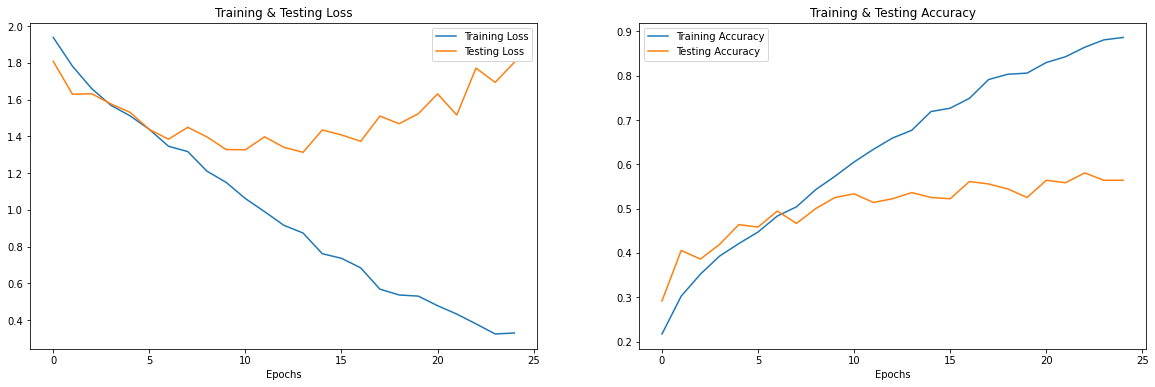

In [81]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(25)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [82]:
model.save('model.tf')

2021-12-11 19:53:30.462331: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model.tf/assets


In [52]:
emotions = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}

In [56]:
model.predict(angry_res.reshape([1, -1, 1]))

array([[0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [83]:
encoder.inverse_transform(model.predict(neutral_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [84]:
encoder.inverse_transform(model.predict(scared_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [85]:
encoder.inverse_transform(model.predict(surprised_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [86]:
encoder.inverse_transform(model.predict(angry_res.reshape([1, -1, 1])))

array([['sad']], dtype=object)

In [87]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [88]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

Predicted Labels Actual Labels
0             angry         angry
1              fear          fear
2          surprise      surprise
3             angry         angry
4           neutral           sad
5           neutral          calm
6              calm          calm
7           disgust          fear
8               sad       disgust
9           disgust       disgust
10            happy         happy
11            angry          fear
12            angry         angry
13             fear           sad
14             calm       neutral
15            angry         angry
16         surprise      surprise
17              sad           sad
18         surprise      surprise
19             fear          fear

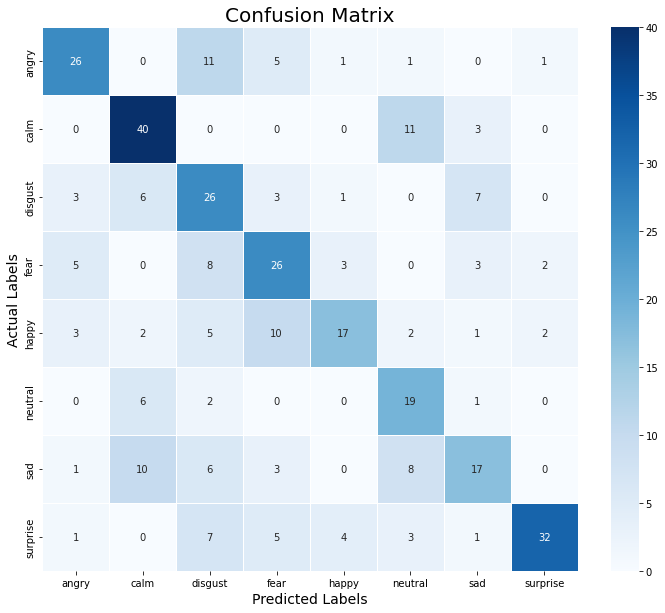

In [89]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [90]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.67      0.58      0.62        45
        calm       0.62      0.74      0.68        54
     disgust       0.40      0.57      0.47        46
        fear       0.50      0.55      0.53        47
       happy       0.65      0.40      0.50        42
     neutral       0.43      0.68      0.53        28
         sad       0.52      0.38      0.44        45
    surprise       0.86      0.60      0.71        53

    accuracy                           0.56       360
   macro avg       0.58      0.56      0.56       360
weighted avg       0.60      0.56      0.57       360



### Above we can see that the model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
### Achieved 62% accuracy on our test data, we can improve it more by applying more augmentation techniques and using other feature extraction methods.